<a href="https://colab.research.google.com/github/samiha-mahin/WaterQuality/blob/main/WQ_RNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/100
97/97 ━━━━━━━━━━━━━━━━━━━━ 5s 8ms/step - accuracy: 0.5058 - loss: 0.9180 - val_accuracy: 0.6565 - val_loss: 0.6594
Epoch 2/100
97/97 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.5448 - loss: 0.7692 - val_accuracy: 0.6342 - val_loss: 0.6527
Epoch 3/100
97/97 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.5875 - loss: 0.7119 - val_accuracy: 0.6406 - val_loss: 0.6381
Epoch 4/100
97/97 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.5882 - loss: 0.6954 - val_accuracy: 0.6310 - val_loss: 0.6331
Epoch 5/100
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.6051 - loss: 0.6853 - val_accuracy: 0.6358 - val_loss: 0.6339
Epoch 6/100
97/97 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.6258 - loss: 0.6465 - val_accuracy: 0.6438 - val_loss: 0.6303
Epoch 7/100
97/97 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.6276 - loss: 0.6451 - val_accuracy: 0.6565 - val_loss: 0.6205
Epoch 8/100
97/97 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.6246 - loss: 0.6454 - val_accuracy: 0.6502 - v

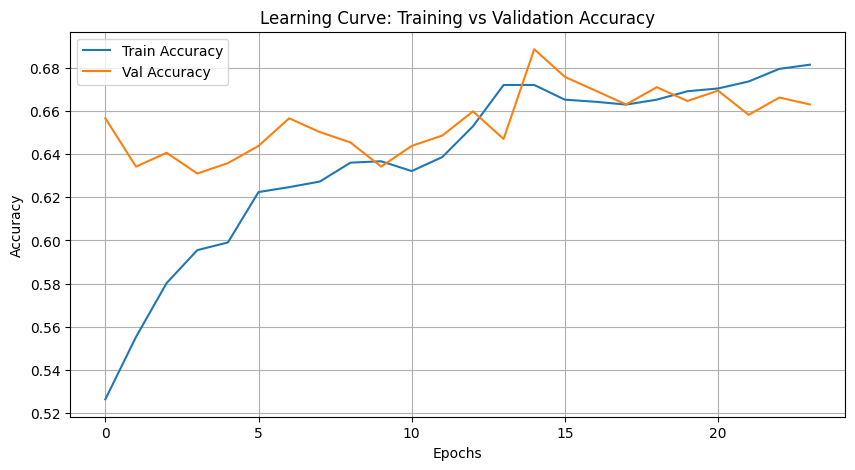

In [ ]:
import pandas as pd
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, classification_report
from imblearn.over_sampling import SMOTE
import matplotlib.pyplot as plt

# Step 1: Load and engineer features
df = pd.read_csv("cleaned_data.csv")

# Feature Engineering
df["Solids_per_Hardness"] = df["Solids"] / (df["Hardness"] + 1e-5)
df["pH_Turbidity"] = df["ph"] * df["Turbidity"]
df["Sulfate_Chloramines"] = df["Sulfate"] * df["Chloramines"]

# Step 2: Features and labels
X = df.drop("Potability", axis=1)
y = df["Potability"]

# Step 3: Train/test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Step 4: Scale the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Step 5: Handle class imbalance using SMOTE (Synthetic Minority Over-sampling Technique)
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_train_scaled, y_train)

# Step 6: Define the neural network model from scratch
def create_model(input_shape):
    model = tf.keras.Sequential([
        tf.keras.layers.Dense(128, activation='relu', input_shape=input_shape),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(0.3),

        tf.keras.layers.Dense(128, activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(0.3),

        tf.keras.layers.Dense(64, activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(0.3),

        tf.keras.layers.Dense(1, activation='sigmoid')
    ])

    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
                  loss='binary_crossentropy',
                  metrics=['accuracy'])

    return model

# Step 7: Create and train the model
model = create_model((X_resampled.shape[1],))  # The input shape is the number of features

# Train the model with early stopping
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

history = model.fit(X_resampled, y_resampled,
                    epochs=100,
                    batch_size=32,
                    validation_data=(X_test_scaled, y_test),
                    callbacks=[early_stopping],
                    verbose=1)

# Step 8: Evaluate the model on test data
y_pred = (model.predict(X_test_scaled) > 0.5).astype("int32")

# Step 9: Evaluate and print performance metrics
accuracy = accuracy_score(y_test, y_pred)
print(f"✅ Deep Learning Accuracy: {accuracy:.4f}")
print("📊 Classification Report:\n", classification_report(y_test, y_pred))

# Step 10: Plot training and validation accuracy
plt.figure(figsize=(10, 5))
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.title('Learning Curve: Training vs Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()
